In [1]:
# IPython magic tools
%load_ext autoreload
%autoreload 2

# Standard library imports
import os
from os import PathLike
import subprocess
from pathlib import Path
from io import BytesIO
from datetime import datetime
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use a non-GUI backend

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import seaborn as sns
import cv2
import pytz
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display

# Custom library imports
from aind_vr_foraging_analysis.utils.parsing import parse, data_access

# Pandas & warning config
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
### Load Patch Foraging Data
session_path = r'\\allen\aind\scratch\vr-foraging\data\778334\fip_test_as_781896\781896_2025-07-18T192910Z'
all_epochs, stream_data, data = data_access.load_session(session_path)

In [95]:
### Load FIP data

FIP_Dir = r'\\allen\aind\scratch\vr-foraging\data\FIP_test\test_2025-08-01T163404Z'
subjectID = "FIP_test"

import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import csv
import glob
import re
from scipy.optimize import curve_fit
import json
import pandas as pd
from scipy.stats import sem

import PreprocessingFunctions_v2 as pf

# for visualization
Roi2Vis = [0]    
AllPlot = 0

# params for pre-processing
nFrame2cut = 100  # crop initial n frames
sampling_rate = 10  # individual channel (not total)
kernelSize = 1  # median filter
degree = 4  # polyfit
b_percentile = 0.70  # To calculate F0, median of bottom x%

StimPeriod = 0.5  # sec for visualization
preW = 50  # nframes for PSTH
LickWindow = 5.0  # sec window length for Consummatory/Omission licks

try: 
    file1 = glob.glob(FIP_Dir + os.sep + "FIP_DataIso_*")[0]
    
except Exception as e:
    file1 = glob.glob(FIP_Dir + os.sep + "iso.csv")[0]
    file2 = glob.glob(FIP_Dir + os.sep + "green.csv")[0]
    file3 = glob.glob(FIP_Dir + os.sep + "red.csv")[0]   
    
else:
    file2 = glob.glob(FIP_Dir + os.sep + "green.csv")[0]
    file3 = glob.glob(FIP_Dir + os.sep + "red.csv")[0]

with open(file1) as f:
    reader = csv.reader(f)
    datatemp = np.array([row for row in reader])
    data1 = datatemp[1:,:].astype(np.float64)
    # del datatemp
    
with open(file2) as f:
    reader = csv.reader(f)
    datatemp = np.array([row for row in reader])
    data2 = datatemp[1:,:].astype(np.float64)
    # del datatemp
    
with open(file3) as f:
    reader = csv.reader(f)
    datatemp = np.array([row for row in reader])
    data3 = datatemp[1:,:].astype(np.float64)
    # del datatemp

#%%
# in case acquisition halted accidentally
Length = np.amin([len(data1),len(data2),len(data3)])

data1 = data1[0:Length] # iso       Time*[TS,ROI0,ROI1,ROI2,..]
data2 = data2[0:Length] # signal
data3 = data3[0:Length] # Stim

PMts = data2[:,0] #SignalTS
time_seconds = np.arange(len(data1)) /sampling_rate

#%% Preprocess
Ctrl_dF_F = np.zeros((data1.shape[0],data1.shape[1]))
G_dF_F = np.zeros((data1.shape[0],data1.shape[1]))
R_dF_F = np.zeros((data1.shape[0],data1.shape[1]))

for ii in range(data2.shape[1]-4):  # -4 to skip the first 4 columns (Fiber 0-3 are columns 4-7)
    Ctrl_dF_F[:, ii] = pf.tc_preprocess(data1[:,ii+4], nFrame2cut, kernelSize, sampling_rate, degree, b_percentile)
    G_dF_F[:, ii] = pf.tc_preprocess(data2[:,ii+4] , nFrame2cut, kernelSize, sampling_rate, degree, b_percentile)
    R_dF_F[:, ii] = pf.tc_preprocess(data3[:,ii+4] , nFrame2cut, kernelSize, sampling_rate, degree, b_percentile)
    


In [96]:
data1[0:100,0]

array([264293.04752 , 264293.097504, 264293.14752 , 264293.197536,
       264293.247552, 264293.297536, 264293.347552, 264293.397568,
       264293.447584, 264293.4976  , 264293.547584, 264293.5976  ,
       264293.647616, 264293.697632, 264293.747648, 264293.797632,
       264293.847648, 264293.897664, 264293.94768 , 264293.997696,
       264294.04768 , 264294.097696, 264294.147712, 264294.197728,
       264294.247712, 264294.297728, 264294.347744, 264294.39776 ,
       264294.447776, 264294.49776 , 264294.547776, 264294.597792,
       264294.647808, 264294.697792, 264294.747808, 264294.797824,
       264294.84784 , 264294.897856, 264294.94784 , 264294.997856,
       264295.047872, 264295.097888, 264295.147904, 264295.197888,
       264295.247904, 264295.29792 , 264295.347936, 264295.39792 ,
       264295.447936, 264295.497952, 264295.547968, 264295.597984,
       264295.647968, 264295.697984, 264295.748   , 264295.798016,
       264295.848   , 264295.898016, 264295.948032, 264295.998

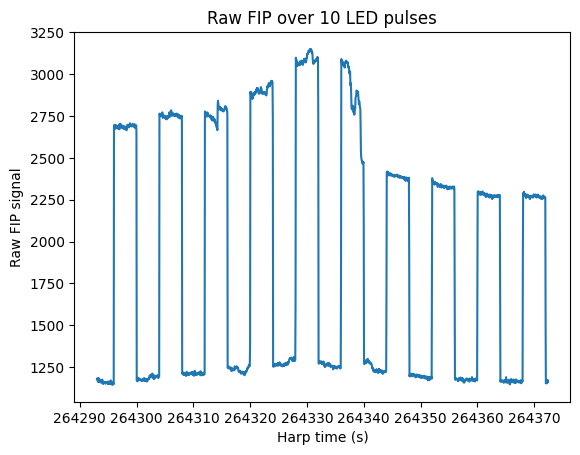

In [106]:
%matplotlib inline
plt.plot(data2[:,0],data2[:,5])
plt.xlabel('Harp time (s)')
plt.ylabel('Raw FIP signal')
plt.title('Raw FIP over 10 LED pulses')
plt.show()

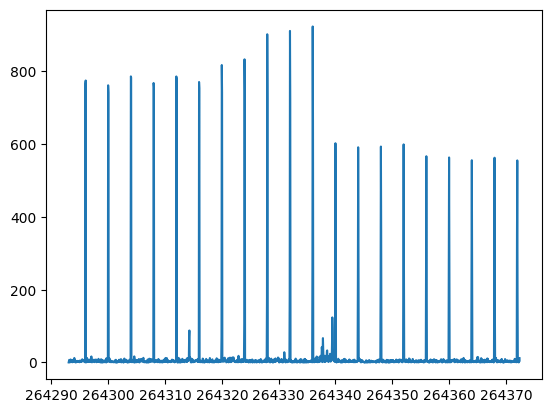

In [105]:
deriv1 = np.gradient(data2[:,5])
plt.plot(data2[:,0],np.abs(deriv1))
plt.show()

[5.19680000e-02 1.95200002e-03 5.12640000e-02 1.24800002e-03
 5.05280000e-02 5.11999999e-04 4.97920000e-02 1.92000007e-04
 4.90880000e-02 9.28000023e-04 2.51360000e-01 3.01344000e-01
 4.83520000e-02 1.66399998e-03 4.76160000e-02 2.36799999e-03
 4.69120000e-02 3.10400000e-03 4.61760000e-02 3.84000002e-03
 4.54400000e-02 4.57599998e-03 4.47360000e-02 5.27999998e-03
 3.94432000e-01 2.44384000e-01 1.94400000e-01 4.05888000e-01
 4.55904000e-01 4.94080000e-01 4.40000000e-02 6.01600000e-03
 4.32960000e-02 6.72000000e-03 4.25600000e-02 7.45600002e-03
 4.18240000e-02 8.16000003e-03 4.11200000e-02 8.89599998e-03
 4.04160000e-02 9.59999999e-03 3.96800000e-02 1.03040000e-02
 3.89760000e-02 1.10400000e-02 3.82720000e-02 1.17440000e-02]


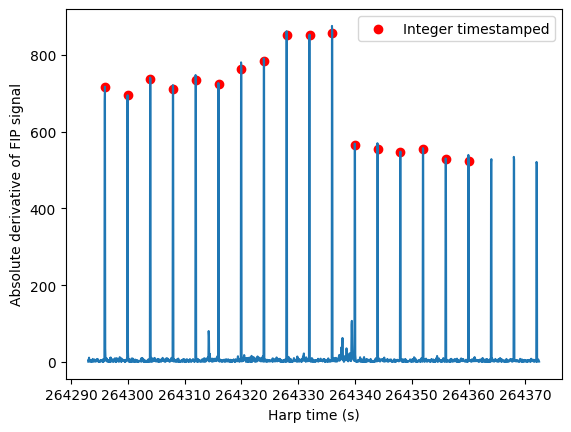

[264295.948032 264295.998048 264299.948736 264299.998752 264303.949472
 264303.999488 264307.950208 264308.000192 264311.950912 264312.000928
 264314.25136  264314.301344 264315.951648 264316.001664 264319.952384
 264320.002368 264323.953088 264324.003104 264327.953824 264328.00384
 264331.95456  264332.004576 264335.955264 264336.00528  264337.605568
 264337.755616 264337.8056   264339.405888 264339.455904 264339.50592
 264339.956    264340.006016 264343.956704 264344.00672  264347.95744
 264348.007456 264351.958176 264352.00816  264355.95888  264356.008896
 264359.959584 264360.0096   264363.96032  264364.010304 264367.961024
 264368.01104  264371.961728 264372.011744]


In [99]:
import numpy as np
import matplotlib.pyplot as plt

x = data1[:,0]  # Harp time in seconds
y = abs(deriv1)  # Absolute value of the derivative

# Step 2: Find where signal has sharp upward transitions
threshold = np.percentile(y, 97)  # tune as needed
rising_edges = np.where(y > threshold)[0]

# Step 3: Get corresponding x-values
rising_times = x[rising_edges]

diffs = abs(rising_times - np.round(rising_times))
print(diffs)

zero_rising_times = rising_times[diffs <= 0.01]
zero_rising_edges = rising_edges[diffs <= 0.01]

# Optional: plot to visualize
plt.plot(x, y)
plt.xlabel('Harp time (s)')
plt.ylabel('Absolute derivative of FIP signal')
plt.scatter(zero_rising_times, y[zero_rising_edges], color='red', label='Integer timestamped')
plt.legend()
plt.show()

print(rising_times)


In [100]:
np.diff(zero_rising_times)

array([4.000704, 4.000736, 4.000704, 4.000736, 4.000736, 4.000704,
       4.000736, 4.000736, 4.000736, 4.000704, 4.000736, 4.000704,
       4.000736, 4.000704, 4.000736, 4.000704])

[-0.051968 -0.001952 -0.051264 -0.001248 -0.050528 -0.000512 -0.049792
  0.000192 -0.049088  0.000928 -0.048352  0.001664 -0.047616  0.002368
 -0.046912  0.003104 -0.046176  0.00384  -0.04544   0.004576 -0.044736
  0.00528  -0.044     0.006016 -0.043296  0.00672  -0.04256   0.007456
 -0.041824  0.00816  -0.04112   0.008896 -0.040416  0.0096   -0.03968
  0.010304 -0.038976  0.01104  -0.038272  0.011744]


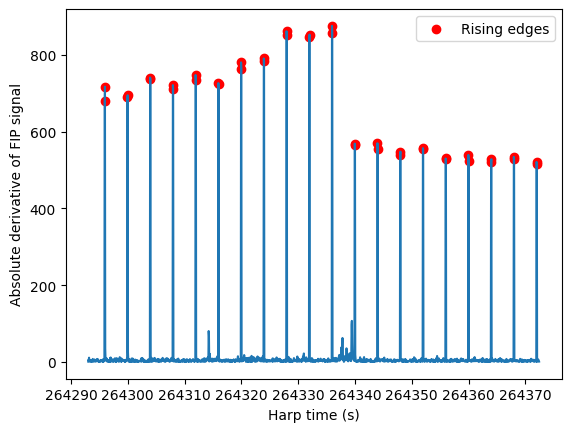

[264295.948032 264295.998048 264299.948736 264299.998752 264303.949472
 264303.999488 264307.950208 264308.000192 264311.950912 264312.000928
 264315.951648 264316.001664 264319.952384 264320.002368 264323.953088
 264324.003104 264327.953824 264328.00384  264331.95456  264332.004576
 264335.955264 264336.00528  264339.956    264340.006016 264343.956704
 264344.00672  264347.95744  264348.007456 264351.958176 264352.00816
 264355.95888  264356.008896 264359.959584 264360.0096   264363.96032
 264364.010304 264367.961024 264368.01104  264371.961728 264372.011744]


In [101]:
x = data1[:,0]  # Harp time in seconds
y = abs(deriv1)  # Absolute value of the derivative

# Step 2: Find where signal has sharp upward transitions
threshold = np.percentile(y, 97.5)  # tune as needed
rising_edges = np.where(y > threshold)[0]

# Step 3: Get corresponding x-values
rising_times = x[rising_edges]

diffs = (rising_times - np.round(rising_times))
print(diffs)

zero_rising_times = rising_times[diffs <= 0.01]
zero_rising_edges = rising_edges[diffs <= 0.01]

# Optional: plot to visualize
plt.plot(x, y)
plt.xlabel('Harp time (s)')
plt.ylabel('Absolute derivative of FIP signal')
plt.scatter(rising_times, y[rising_edges], color='red', label='Rising edges')
plt.legend()
plt.show()

print(rising_times)

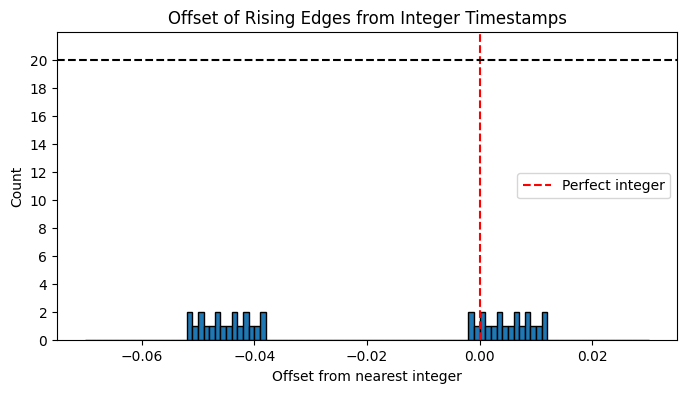

In [102]:
from matplotlib.ticker import MaxNLocator

# Histogram of fractional parts (to check alignment to integers)
fractional_offset = rising_times - np.round(rising_times)

plt.figure(figsize=(8, 4))
plt.hist(fractional_offset, bins=100, range=(-0.07, 0.03), edgecolor='black')
plt.xlabel("Offset from nearest integer")
plt.ylabel("Count")
plt.ylim(0,22)
yticks = np.arange(0, 22, 2)  # from -0.07 to 0.03 in steps of 0.02 (~every 2%)
plt.yticks(yticks)

plt.title("Offset of Rising Edges from Integer Timestamps")
plt.axvline(0, color='red', linestyle='--', label='Perfect integer')
plt.axhline(20, color='black', linestyle='--')
#plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()


264303.906250 → diff from nearest int: 9.375000e-02
264303.937500 → diff from nearest int: 6.250000e-02
264304.000000 → diff from nearest int: 0.000000e+00
264304.062500 → diff from nearest int: 6.250000e-02
264308.000000 → diff from nearest int: 0.000000e+00
264311.906250 → diff from nearest int: 9.375000e-02
264311.937500 → diff from nearest int: 6.250000e-02
264312.000000 → diff from nearest int: 0.000000e+00
264312.062500 → diff from nearest int: 6.250000e-02
264315.937500 → diff from nearest int: 6.250000e-02
264316.000000 → diff from nearest int: 0.000000e+00
264316.062500 → diff from nearest int: 6.250000e-02
264319.906250 → diff from nearest int: 9.375000e-02
264319.937500 → diff from nearest int: 6.250000e-02
264320.000000 → diff from nearest int: 0.000000e+00
264320.062500 → diff from nearest int: 6.250000e-02
264323.906250 → diff from nearest int: 9.375000e-02
264323.937500 → diff from nearest int: 6.250000e-02
264324.000000 → diff from nearest int: 0.000000e+00
264324.06250

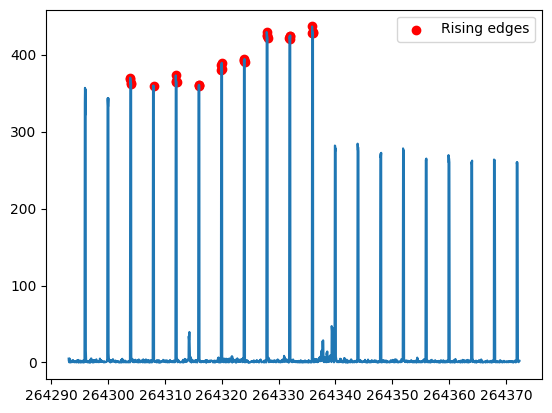

In [28]:
x = data1[:,0]  # Harp time in seconds
y2 = abs(np.gradient(y))  # Absolute value of the derivative

# Step 2: Find where signal has sharp upward transitions
threshold = np.percentile(y2, 98)  # tune as needed
rising_edges = np.where(y2 > threshold)[0]

# Step 3: Get corresponding x-values
rising_times = x[rising_edges]

# Step 4: Print or plot how close they are to integers
for t in rising_times:
    print(f"{t:.6f} → diff from nearest int: {abs(t - round(t)):.6e}")

# Optional: plot to visualize
plt.plot(x, y2)
plt.scatter(rising_times, y2[rising_edges], color='red', label='Rising edges')
plt.legend()
plt.show()

In [6]:
#%% PSTH functions (for multiple traces)
def PSTHmaker(TC, Stims, preW, postW):
    cnt = 0  
    if Stims - preW >= 0 and  Stims + postW < len(TC):
        A = int(Stims-preW) 
        B = int(Stims+postW)  
        if cnt == 0:
            PSTHout = TC[A:B,:]
            cnt = 1
        else:
            PSTHout = np.dstack([PSTHout,TC[A:B,:]])
    else:
        if cnt == 0:
            PSTHout = np.zeros(preW+postW)
            cnt = 1
        #else:
            #PSTHout = np.dstack([PSTHout, np.zeros(preW+postW)])
    return PSTHout

#%%
def PSTHplot(PSTH, MainColor, SubColor, LabelStr):
    plt.plot(np.arange(np.shape(PSTH)[1])/20 - preW/sampling_rate, np.mean(PSTH.T,axis=1),label=LabelStr,color = MainColor, linewidth=0.5)
    #plt.plot(np.arange(np.shape(PSTH)[1])/20 - 5, np.mean(PSTH.T,axis=1) + np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0]),color = SubColor, linestyle = "dotted")
    #plt.plot(np.arange(np.shape(PSTH)[1])/20 - 5, np.mean(PSTH.T,axis=1) - np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0]),color = SubColor, linestyle = "dotted")
    # y11 =  np.mean(PSTH.T,axis=1) + np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0])
    # y22 =  np.mean(PSTH.T,axis=1) - np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0])
    # plt.fill_between(np.arange(np.shape(PSTH)[1])/20 - preW/sampling_rate, y11, y22, facecolor=SubColor, alpha=0.5)


#%% PSTH baseline subtraction (multi)
#dim0:trial, dim1:time
def PSTH_baseline(PSTH, preW):
   
    Trace_this = PSTH[:, :]
    Trace_this_base = Trace_this[0:preW,:]
    Trace_this_subtracted = Trace_this - np.mean(Trace_this_base,axis=0)

    PSTHbase = Trace_this_subtracted

    return PSTHbase

In [67]:
def plot_FIP_odorsite(patch_num, fiber_nums):
    %matplotlib inline

    preW = 50
    start, odor_end, patch_label = odor_sites[patch_num]

    color_map = {'PatchA': 'red', 'PatchB': 'blue', 'PatchC': 'green'}
    colorcode = color_map.get(patch_label, 'gray')

    plot_end = odor_end + 5  # extend visualization window

    # Frame indexing based on time
    startFrame = np.argmin(np.abs(data1[:, 0] - start))
    endFrame = np.argmin(np.abs(data1[:, 0] - plot_end))

    # Generate PSTHs and baseline-correct
    Psth_G = PSTHmaker(G_dF_F * 100, startFrame, preW, endFrame - startFrame)
    Psth_R = PSTHmaker(R_dF_F * 100, startFrame, preW, endFrame - startFrame)
    Psth_C = PSTHmaker(Ctrl_dF_F * 100, startFrame, preW, endFrame - startFrame)

    Psth_G_base = PSTH_baseline(Psth_G, preW)
    Psth_R_base = PSTH_baseline(Psth_R, preW)
    Psth_C_base = PSTH_baseline(Psth_C, preW)

    # Create subplots: one per fiber + one for velocity
    n_fibers = len(fiber_nums)
    fig, axes = plt.subplots(n_fibers + 1, 1, figsize=(10, 2.5 * (n_fibers + 1)), sharex=True)

    fig.suptitle(f'Odor Site {patch_num}, {patch_label}', fontsize=11)

    # Shared time vector for PSTHs
    psth_time = np.arange(Psth_G_base.shape[0]) / sampling_rate - preW / sampling_rate

    # Plot each fiber's dF/F
    for i, fiber_num in enumerate(fiber_nums):
        ax = axes[i]
        ax.plot(psth_time, Psth_G_base[:, fiber_num], label="Green- dLight", color="g", linewidth=0.5)
        ax.plot(psth_time, Psth_R_base[:, fiber_num], label="Red- rACh", color="r", linewidth=0.5)
        ax.plot(psth_time, Psth_C_base[:, fiber_num], label="Iso", color="b", linewidth=0.5)
        ax.axvspan(0, odor_end - start, color=colorcode, alpha=0.3)
        ax.set_ylabel(f'dF/F (%)\nFiber {fiber_num}')
        ax.set_xlim(psth_time.min(), psth_time.max())
        if i == 0:
            ax.legend(loc='upper right', fontsize=6)

    # Plot velocity in final subplot
    ax_vel = axes[-1]
    velocity = stream_data.encoder_data.filtered_velocity[start - int(preW / sampling_rate):plot_end]
    velocity_time = np.arange(len(velocity)) / 250 - preW / sampling_rate
    ax_vel.plot(velocity_time, velocity)
    ax_vel.axvspan(0, odor_end - start, color=colorcode, alpha=0.3)
    ax_vel.set_ylabel('Velocity (cm/s)')
    ax_vel.set_xlabel('Time from odor onset (s)')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


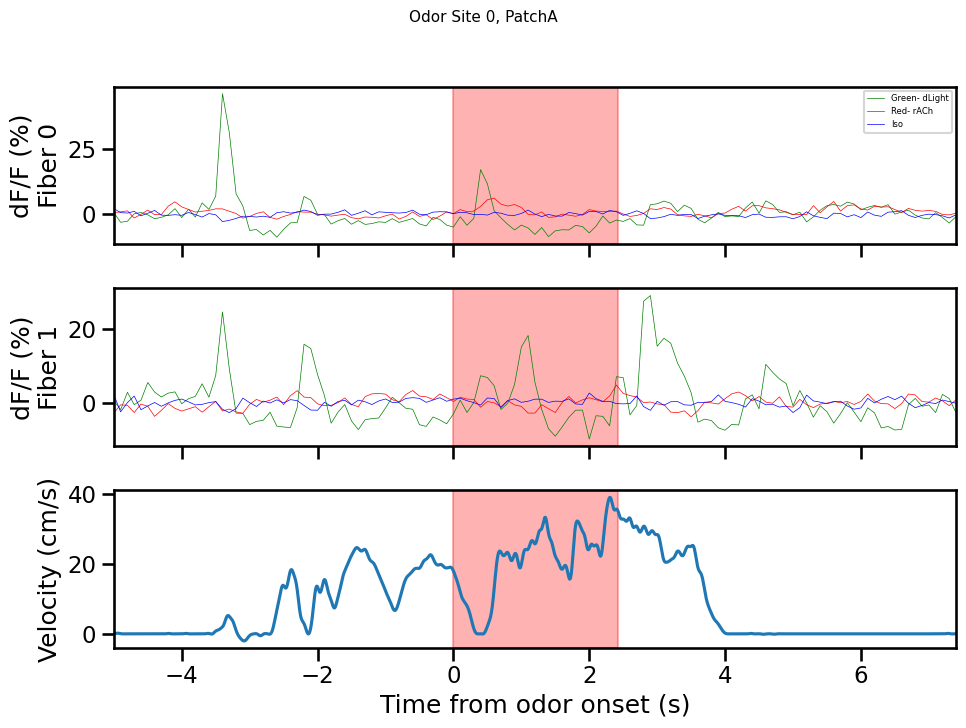

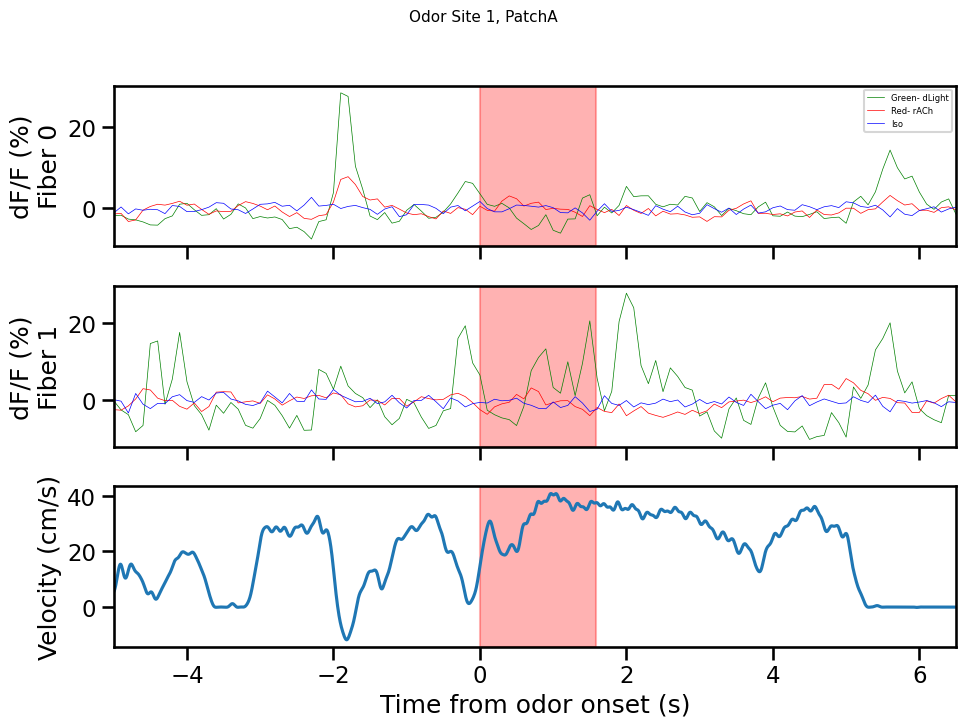

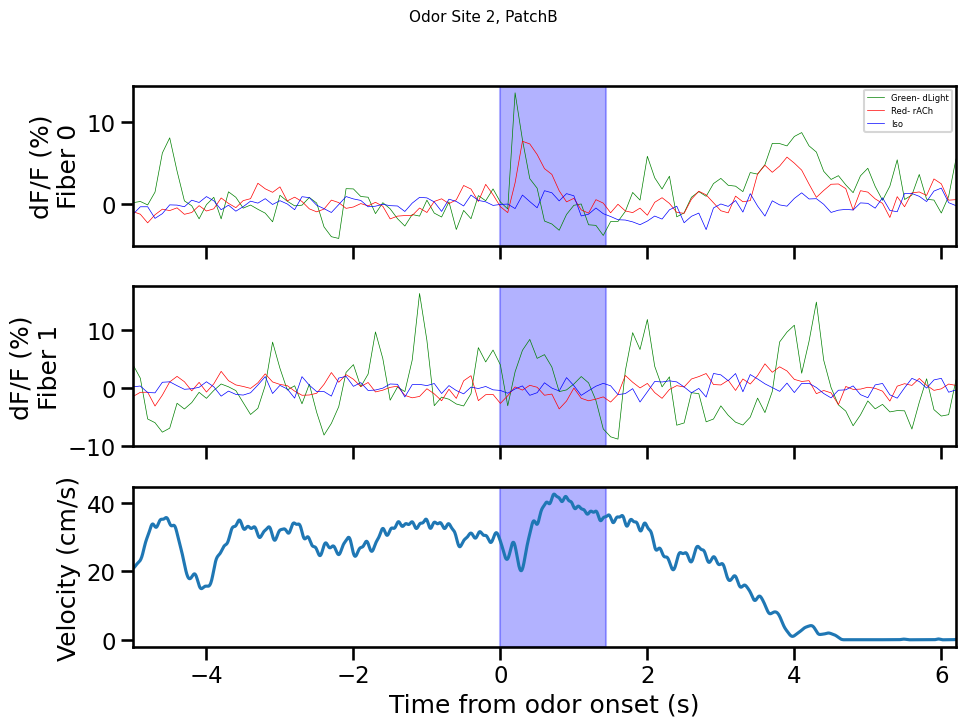

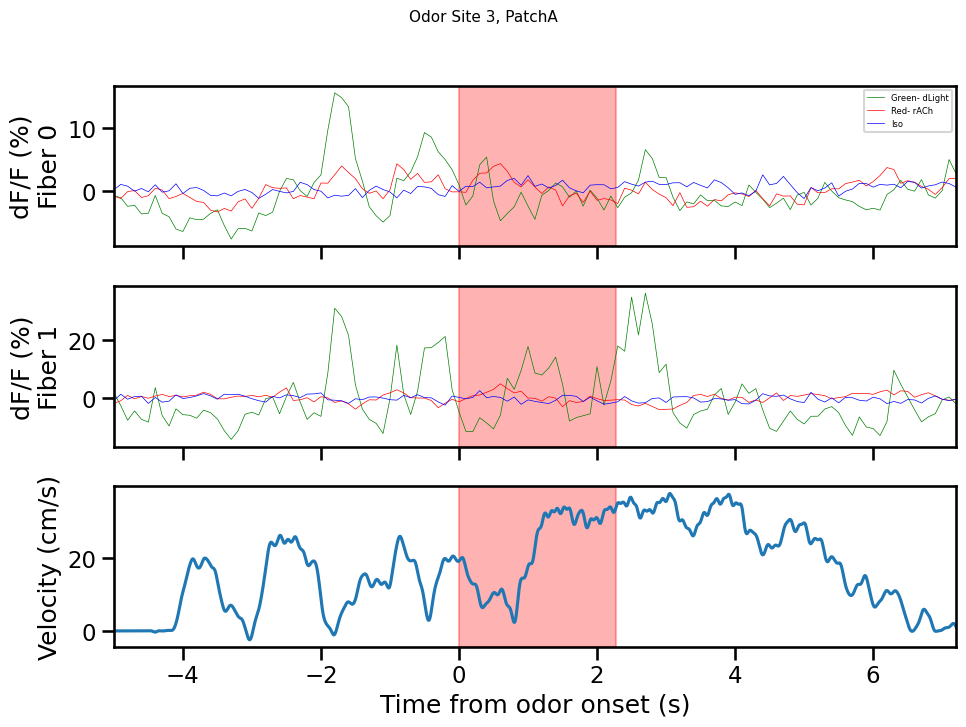

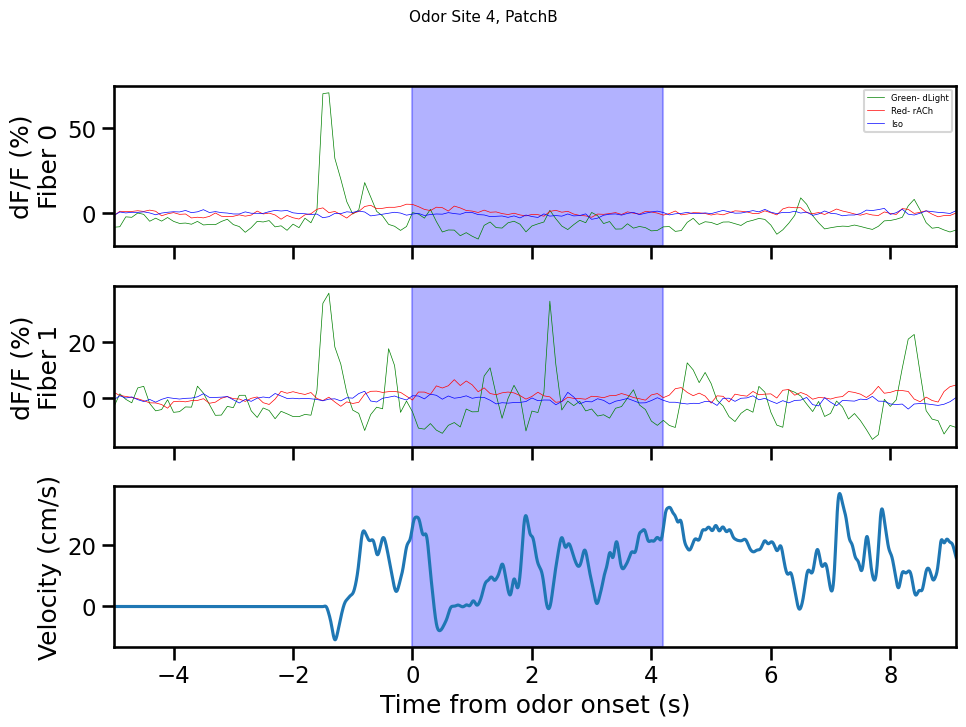

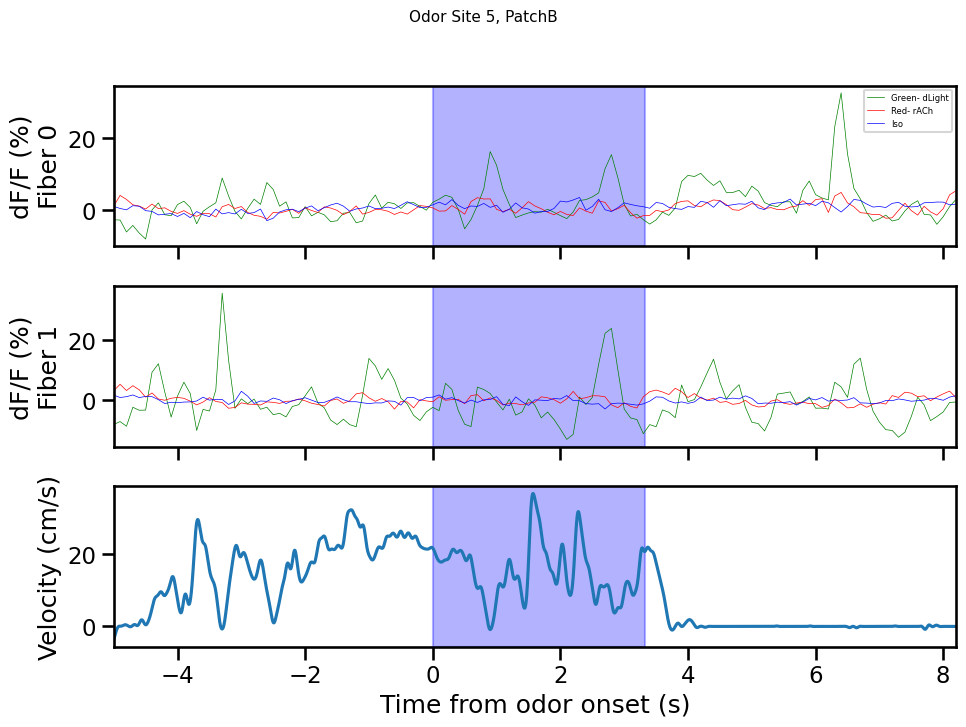

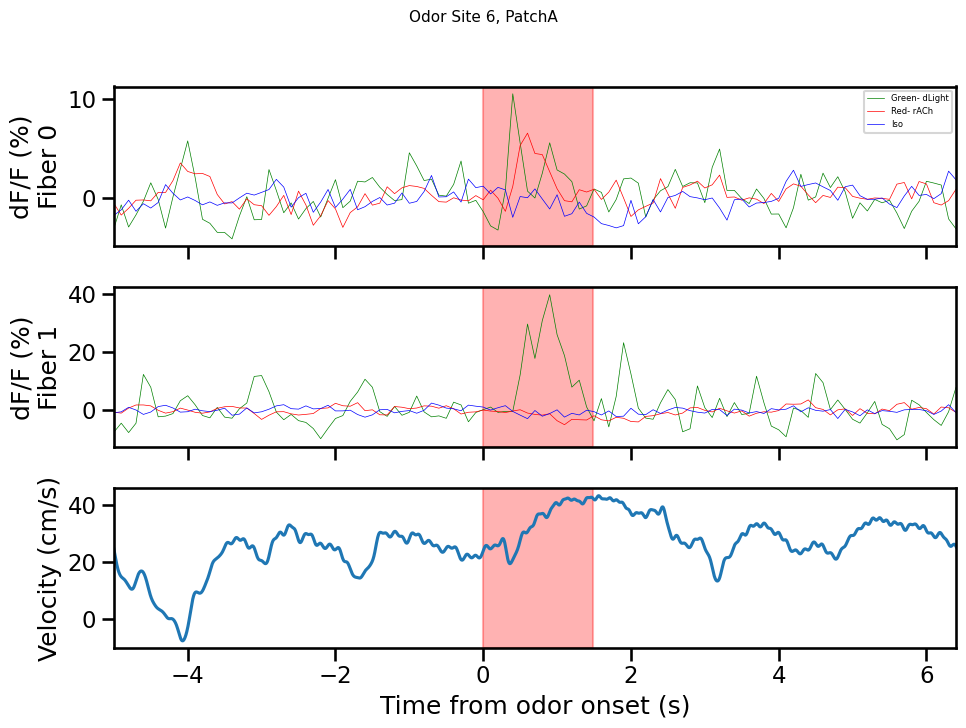

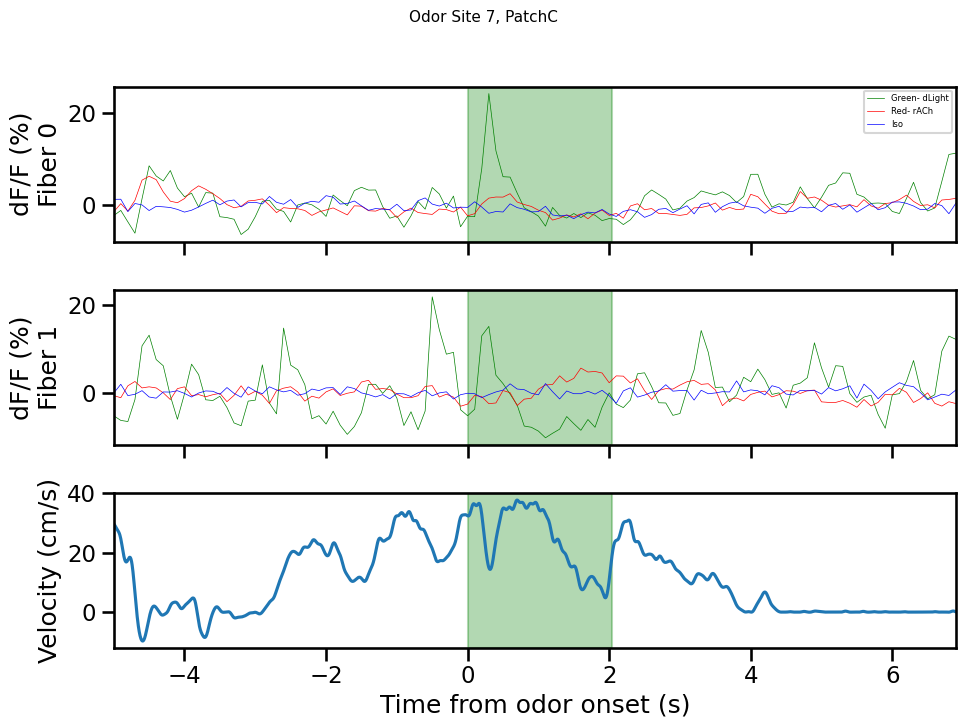

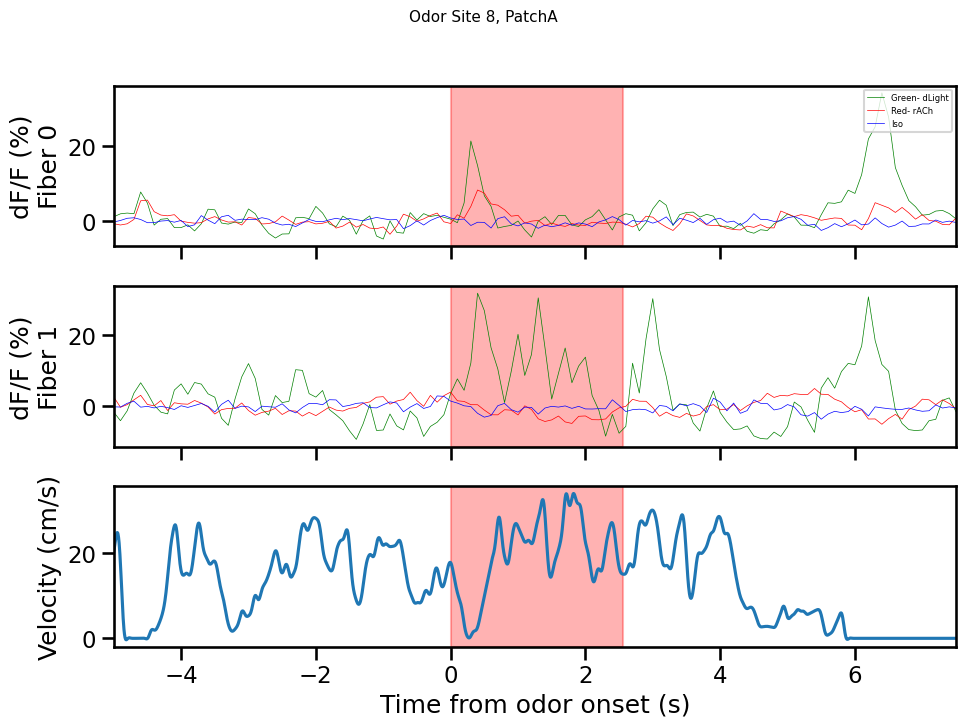

In [68]:
for i in range(len(odor_sites)):
    plot_FIP_odorsite(i,[0,1])

# Fiber 0 = NAc, Fiber 1 = DMS. Green = dLight, Red = rACh